# Create combined feature table from list of feature-table files

We have a number of feature files that are suitable for different aggregation levels,
 
 - `Store-Open`: At `['hsc', 'shift', 'delivery_type']` level
 - `MOV`: at `['hsc']` level
 - `promotion themes`: equal across all groups
 - `time features`: equal across all groups

For modelling it makes file I/O easier if for every forecast group, such as `1384_PA_HD_B2B`, we create a separate
table of features. The table for `1384_PA_HD_B2B` or `1384_PA_HD` may be different because their aggregation levels are different.

This notebooks expects that for every feature you want to include in the feature table output you add
a pre-processed feature file appropriate for the group you want. So for group `1384_PA` you will already have
aggregated the `Store-Open` feature to the `['hsc', 'shift']` level, and feed it as input to this notebook


- hsc: delivery location number
- shift: PA / PO
- delivery_type: PUP / HD
- customer_type: B2B / B2C

Each of these groups may be used for separate models and use different external features.

# Set parameters

Parameters

----------
- input_file: String filepath of databricks .csv export from forecasting.orders_aggregated_compact_vw
- output_dir: String filepath to write output files to for each group
- base_name: (Optional) String to prefix output filenames

Returns

-------
Files named `{output_dir}/{base_name}__group_{group_level}.csv`.

Where `group_level` comes from unique values in the `group` column of the `input_file`.


In [1]:
# for user defaults and interactive use
hsc = "1384"
shift = "PA"
delivery_type = None

In [2]:
# list of feature files with only datetime column 'ds' and named numerical feature columns
features = ["../data/features/SOpen_%s.csv" % "_".join([x for x in (hsc, shift, delivery_type) if x is not None]),
            "../data/features/MOV_%s.csv" % (hsc),
            "../data/features/daily_time_features.csv",
            "../data/features/promotion_theme.csv",
            "../data/features/holidays_RijksOverheid.csv"]

output_file = "tmp_dump/combined_features.csv"

In [3]:
# if given as a string, separate filenames by '+'
if type(features) is str:
    features = features.split("+")
print("Feature files to combine:\n", features)
print("\nWriting all features into a single file: ", output_file)

Feature files to combine:
 ['../data/features/SOpen_1384_PA.csv', '../data/features/MOV_1384.csv', '../data/features/daily_time_features.csv', '../data/features/promotion_theme.csv', '../data/features/holidays_RijksOverheid.csv']

Writing all features into a single file:  tmp_dump/combined_features.csv


# Load packages

Uses **conda environment: envs/py-forecasting.yaml**



In [4]:
import sys
sys.path.append("../")

from src.utilities.indexers import id_to_index, date_from_index
from src.utilities.loaders import load_features

import os

import pandas as pd
from pathlib import Path

In [5]:
%matplotlib inline

In [6]:
features_list = []
for feature_file in features:
    df_tmp_feature = pd.read_csv(feature_file, index_col=None)
    df_tmp_feature["ds"] = pd.to_datetime(df_tmp_feature["ds"]).apply(lambda x: x.date())
    
    features_list.append(df_tmp_feature)

In [7]:
from functools import reduce
# merge all dataframes in a list on 'ds' column
## result is that only dates in 'ds' are included that are known for all features
df_features = reduce(lambda left,right: pd.merge(left,right,on='ds'), features_list)
df_features.head()

,ds,SOpen,MOV,dayofweek,quarter,month,year,dayofmonth,weekofyear,Promo,...,Voorjaarsvakantie_noord,Zomervakantie_noord,Herfstvakantie_midden,Voorjaarsvakantie_midden,Zomervakantie_midden,Herfstvakantie_zuid,Voorjaarsvakantie_zuid,Zomervakantie_zuid,Kerstvakantie_heelNederland,Meivakantie_heelNederland
0,2017-01-02,1.0,70,0,1,1,2017,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2017-01-03,1.0,70,1,1,1,2017,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2017-01-04,1.0,70,2,1,1,2017,4,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2017-01-05,1.0,70,3,1,1,2017,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2017-01-06,1.0,70,4,1,1,2017,6,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Validate output

- Differences between all observations exactly 1 day

In [8]:
# Assert some assumptions about the data
df_date_diffs = df_features \
    .sort_values("ds") \
    ["ds"].diff().dt.days

# assert that all dates per group are exactly 1 day apart
date_diff_ok = all(df_date_diffs.fillna(1) == 1)
if date_diff_ok:
    print("SUCCESS: Date difference between all observations exactly 1 day")
else:
    # todo: show exactly where we found unexpected results
    print("FAILURE: Date differences not all exactly 1 day!")

min(df_features["ds"]), max(df_features["ds"])

SUCCESS: Date difference between all observations exactly 1 day


(datetime.date(2017, 1, 2), datetime.date(2020, 2, 29))

# Visualize features

Feature values may be normalized for sake of visualisation, but the unnormalized values will be saved in the output.

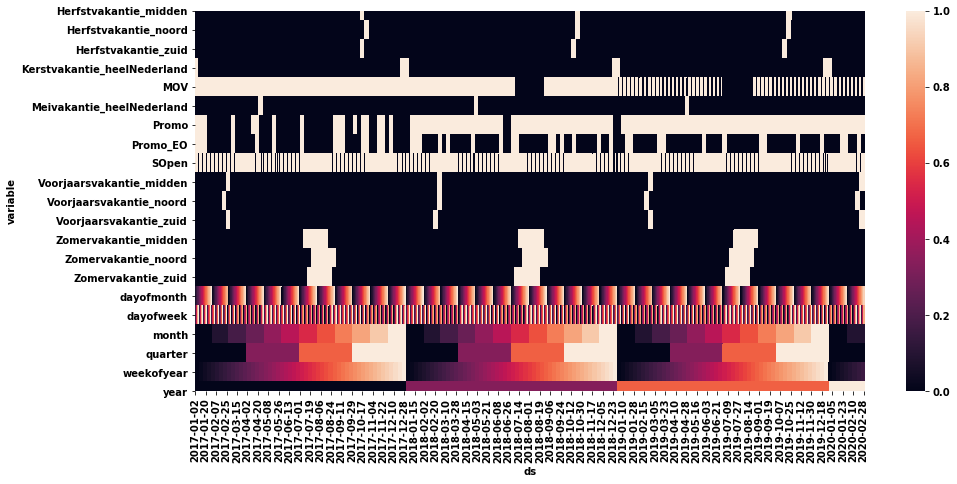

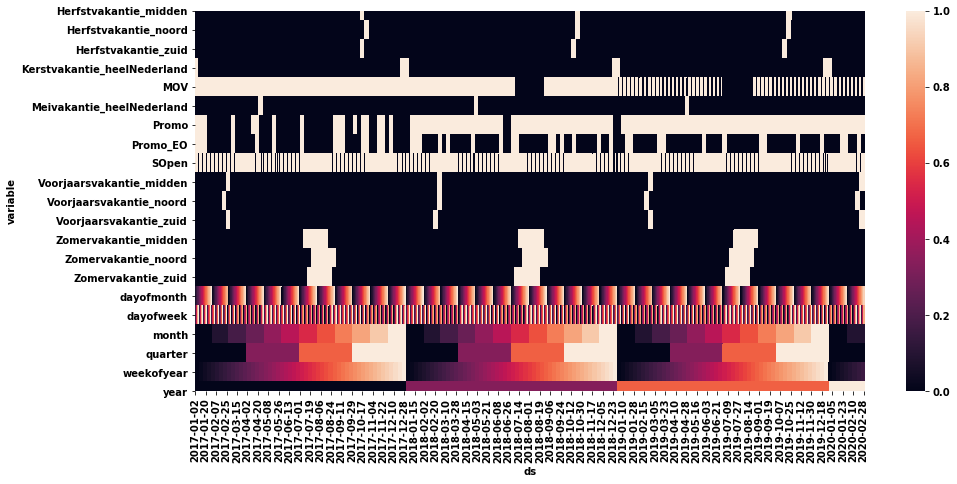

In [9]:
from src.visualization.static import plot_features_on_heatmap
fig = plot_features_on_heatmap(df_features, 
                         [x for x in df_features.columns if x != "ds"], 
                         id_var="ds")
fig

# Write output

In [26]:
df_features.to_csv(output_file, index=None)
print("Written output to: ", output_file)

Written output to:  tmp_dump/combined_features.csv


# Information about processed data

In [27]:
# unsplit data
df_features.head()

,ds,SOpen,MOV,dayofweek,quarter,month,year,dayofmonth,weekofyear,Promo,...,Voorjaarsvakantie_noord,Zomervakantie_noord,Herfstvakantie_midden,Voorjaarsvakantie_midden,Zomervakantie_midden,Herfstvakantie_zuid,Voorjaarsvakantie_zuid,Zomervakantie_zuid,Kerstvakantie_heelNederland,Meivakantie_heelNederland
0,2017-01-02,1.0,70,0,1,1,2017,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2017-01-03,1.0,70,1,1,1,2017,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2017-01-04,1.0,70,2,1,1,2017,4,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2017-01-05,1.0,70,3,1,1,2017,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2017-01-06,1.0,70,4,1,1,2017,6,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
# describe all columns of the unsplit data
df_features.describe(include='all')

,ds,SOpen,MOV,dayofweek,quarter,month,year,dayofmonth,weekofyear,Promo,...,Voorjaarsvakantie_noord,Zomervakantie_noord,Herfstvakantie_midden,Voorjaarsvakantie_midden,Zomervakantie_midden,Herfstvakantie_zuid,Voorjaarsvakantie_zuid,Zomervakantie_zuid,Kerstvakantie_heelNederland,Meivakantie_heelNederland
count,1092,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,...,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
unique,1092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-10-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2017-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.841575,65.934066,3.000000,2.508242,6.521062,2017.999084,15.706960,26.500000,0.743590,...,0.021978,0.119048,0.023810,0.021978,0.119048,0.022894,0.022894,0.119048,0.041209,0.021978
std,NaN,0.365306,8.052717,2.000916,1.116055,3.442139,0.816309,8.778266,15.015208,0.436851,...,0.146679,0.323993,0.152525,0.146679,0.323993,0.149633,0.149633,0.323993,0.198864,0.146679
min,NaN,0.000000,50.000000,0.000000,1.000000,1.000000,2017.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.000000,70.000000,1.000000,2.000000,4.000000,2017.000000,8.000000,13.750000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
